In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from IPython import display
import time

###### Parameters ######

device = 'cuda'
ndim = 2048
embed = 128
batch_size_train = 64
batch_size_test = 64
nepochs = 1000


learning_rate_adam = 1e-4


hlyrs = 512

nclasses_d = 2
nclasses_p = 31

lamb=1e-2

###### Data loading ######

dataroot = './data/Office31_resnet/'

## Choosing source and target domain ##
####  A - > D ####
name='A to D'
input_filename_train= 'amazon_amazon.csv'
input_filename_test = 'amazon_dslr.csv'
####  A - > W ####
# name='A to W'
# input_filename_train= 'amazon_amazon.csv'
# input_filename_test = 'amazon_webcam.csv'
####  D - > A ####git
# name='D to A'
# input_filename_train= 'dslr_dslr.csv'
# input_filename_test = 'dslr_amazon.csv'
####  D - > W ####
# name='D to W'
# input_filename_train= 'dslr_dslr.csv'
# input_filename_test = 'dslr_webcam.csv'

####  W - > A ####
# name='W to A'
# input_filename_train= 'webcam_webcam.csv'
# input_filename_test = 'webcam_amazon.csv'
####  W - > D ####
# name='W to D'
# input_filename_train= 'webcam_webcam.csv'
# input_filename_test = 'webcam_dslr.csv'

###### ploting figure #####

train_loss_list=list()
train_loss_D_list=list()
train_acc_list=list()
test_loss_list=list()
test_acc_list=list()


###### model ######

class DA_Net(nn.Module):
    def __init__(self, indim=ndim, embedding=embed, hdlayers=hlyrs,num_dc=nclasses_d,num_p=nclasses_p,):
        super(DA_Net,self).__init__()
        #### Extractor ####
        self.model1 = nn.Sequential(
            nn.Linear(indim, hdlayers),
            nn.BatchNorm1d(hdlayers),
            nn.PReLU(),
            nn.Dropout(0.5),
            nn.Linear(hdlayers, int(hdlayers / 2)),
            # nn.BatchNorm1d(int(hdlayers/2)),
            nn.PReLU(),
            # nn.Linear(int(hdlayers / 2), int(hdlayers / 4)),
            # # nn.BatchNorm1d(int(hdlayers/2)),
            # nn.PReLU(),
        )
        self.classlayer = nn.Linear(int(hdlayers / 2), embedding)

        #### Domain_Classifier ####
        self.dc_fc1 = nn.Linear(embedding, num_dc)
        self.dc_softmaxlayer = nn.Softmax(dim=1)

        #### Predictor ####
        self.p_fc1 = nn.Linear(embedding, num_p)
        # self.p_fc2 = nn.Linear(int(embedding/2), num_p)
        self.p_softmaxlayer = nn.Softmax(dim=1)

    def forward(self, x):

        z = self.model1(x)
        out = self.classlayer(z)
        feature = out / (torch.norm(out, dim=1)[:, None] + 1e-16)


        out_d = self.dc_fc1(feature.detach())
        prob_d = self.dc_softmaxlayer(out_d) + 1e-16


        out_p = self.p_fc1(feature)

        prob_p = self.p_softmaxlayer(out_p) + 1e-16


        return out_d,out_p



class Office31(Dataset):
    def __init__(self, ifile, root=None, train=True):

        self.root = root
        self.ifile = ifile

        data = np.loadtxt( self.root  + self.ifile, dtype=float, delimiter=',')

        if train:
            self.data=np.hstack((data, np.zeros((len(data),1))))
            self.feature = torch.from_numpy(self.data[:, 0:-2]).float()
            self.feature=(self.feature-self.feature.min())/(self.feature.max()-self.feature.min())
            self.T = torch.from_numpy(self.data[:, -2])
            self.S = torch.from_numpy(self.data[:, -1])

        else:
            self.data = np.hstack((data, np.ones((len(data),1))))
            self.feature = torch.from_numpy(self.data[:, 0:-2]).float()
            self.feature = (self.feature - self.feature.min()) / (self.feature.max() - self.feature.min())
            self.T = torch.from_numpy(self.data[:, -2])
            self.S = torch.from_numpy(self.data[:, -1])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        feature, T, S=self.feature[index], self.T[index], self.S[index]


        return feature, T, S


dataset_train = Office31(input_filename_train,root=dataroot,train=True)
dataset_test = Office31(input_filename_test,root=dataroot,train=False)

Source = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=batch_size_train, shuffle=True)

Target = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size_test, shuffle=False)


model=DA_Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate_adam)
optimizer_D = optim.Adam(model.parameters(), lr=learning_rate_adam)
###### Train and Test ######
def train(epoch):
    model.train()

    Loss_predict = torch.nn.CrossEntropyLoss()
    Loss_domain = torch.nn.CrossEntropyLoss()

    train_loss = 0.0
    train_loss_D=0.0
    train_acc = 0.0

    t=0

    for (i,(inputs_SD, labels_SD, domain_SD)),(i,(inputs_TD, labels_TD, domain_TD)) in zip(enumerate(Source),enumerate(Target)):
        batch_size_S = inputs_SD.size(0)
        batch_size_T = inputs_TD.size(0)


        inputs_SD=inputs_SD
        labels_SD=labels_SD
        domain_SD=domain_SD

        inputs_TD=inputs_TD
        labels_TD=labels_TD
        domain_TD=domain_TD

        inputs_SD_t=torch.FloatTensor(batch_size_S, ndim)
        inputs_SD_t.resize_(inputs_SD.size()).copy_(inputs_SD)
        inputs_SD_t=inputs_SD_t.to(device)

        labels_SD_t =torch.zeros(batch_size_S)
        labels_SD_t.resize_(labels_SD.size()).copy_(labels_SD)
        labels_SD_t=labels_SD_t.to(device)

        domain_SD_t =torch.zeros(batch_size_S)
        domain_SD_t.resize_(domain_SD.size()).copy_(domain_SD)
        domain_SD_t=domain_SD_t.to(device)

        inputs_TD_t = torch.FloatTensor(batch_size_T, ndim)
        inputs_TD_t.resize_(inputs_TD.size()).copy_(inputs_TD)
        inputs_TD_t=inputs_TD_t.to(device)

        labels_TD_t =torch.zeros(batch_size_T)
        labels_TD_t.resize_(labels_TD.size()).copy_(labels_TD)
        labels_TD_t=labels_TD_t.to(device)

        domain_TD_t =torch.zeros(batch_size_T)
        domain_TD_t.resize_(domain_TD.size()).copy_(domain_TD)
        domain_TD_t=domain_TD_t.to(device)

        #### train predictor and train domain_classifier####

        S_domain_out,S_label_out=model(inputs_SD_t)
        err_S_predict = Loss_predict(S_label_out, labels_SD_t.long())
        err_S_domain = Loss_domain(S_domain_out, domain_SD_t.long())

        T_domain_out, _ = model(inputs_TD_t)

        err_T_domain = Loss_domain(T_domain_out , domain_TD_t.long())

        loss =err_S_predict
        loss_D=-lamb*(err_S_domain + err_T_domain)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        train_loss+=loss*batch_size_S
        train_loss_D+=loss_D*batch_size_S

        #### train acc ####
        pred = S_label_out.data.max(1)[1].view(-1, 1).squeeze()
        acc = pred.eq(labels_SD_t.data).cpu().sum().float() * 100 / batch_size_S

        train_acc+=acc*batch_size_S

        t+=batch_size_S


    train_loss= train_loss/t
    train_loss_D = train_loss_D /t
    train_acc = train_acc/t

    # import pdb; pdb.set_trace()
    return train_loss.data.cpu(),train_loss_D.data.cpu(), train_acc.data.cpu()

def test():
    model.eval()

    Loss_predict = torch.nn.CrossEntropyLoss()
    Loss_domain = torch.nn.CrossEntropyLoss()

    test_loss = 0.0
    test_acc = 0.0
    t=0
    for (i, (inputs_TD, labels_TD, domain_TD)) in enumerate(Target):

        batch_size_T = inputs_TD.size(0)

        inputs_TD = inputs_TD
        labels_TD = labels_TD
        domain_TD = domain_TD

        inputs_TD_t = torch.FloatTensor(batch_size_T, ndim)
        inputs_TD_t.resize_(inputs_TD.size()).copy_(inputs_TD)
        inputs_TD_t = inputs_TD_t.to(device)

        labels_TD_t = torch.zeros(batch_size_T)
        labels_TD_t.resize_(labels_TD.size()).copy_(labels_TD)
        labels_TD_t = labels_TD_t.to(device)

        domain_TD_t = torch.zeros(batch_size_T)
        domain_TD_t.resize_(domain_TD.size()).copy_(domain_TD)
        domain_TD_t = domain_TD_t.to(device)

        #### train predictor and train domain_classifier####

        T_domain_out, T_label_out = model(inputs_TD_t)
        err_T_predict = Loss_predict(T_label_out, labels_TD_t.long())
        err_T_domain = Loss_domain(T_domain_out, domain_TD_t.long())

        loss = err_T_predict

        optimizer.zero_grad()


        test_loss += loss * batch_size_T

        #### train acc ####
        pred = T_label_out.data.max(1)[1].view(-1, 1).squeeze()
        acc = pred.eq(labels_TD_t.data).cpu().sum().float() * 100 / batch_size_T
        test_acc += acc * batch_size_T
        t+=1

    test_loss = test_loss / (len(dataset_test))
    test_acc = test_acc / (len(dataset_test))

    return test_loss.data.cpu(), test_acc.data.cpu()
######################################################################################
# visualization
def plot_distributions(train_loss_list,train_acc_list,test_loss_list,test_acc_list, nsteps):
    
    fig = plt.figure(figsize=(10, 5))

    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    ax1.plot(np.arange(nsteps + 1), np.array(train_loss_list), label='Train Loss')
    ax1.plot(np.arange(nsteps + 1), np.array(test_loss_list), label='Test Loss')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='best')

    # ax2.plot(np.arange(nsteps + 1), np.array(train_acc_list), label='Train Acc')
    ax2.plot(np.arange(nsteps + 1), np.array(test_acc_list), label=name+' Acc')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='best')

    plt.tight_layout()

    plt.tight_layout()
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.close(fig)
    time.sleep(0.1)

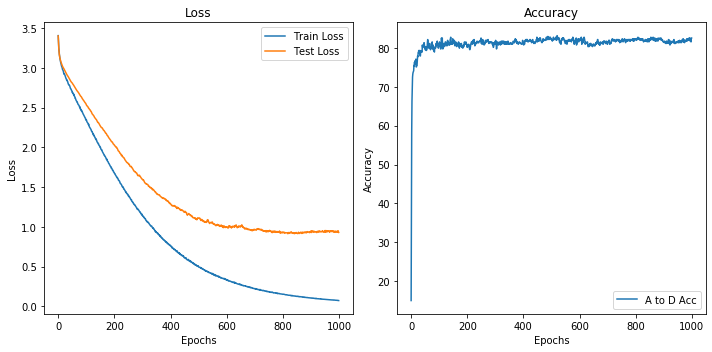

In [9]:
######################################################################################
# main

for epoch in range(nepochs):

    train_loss,train_loss_D, train_acc = train(epoch)
    print('Train Epoch: {} \tLoss: {:.6f}\tLoss D: {:.6f}\tAcc: {:.6f}'.format(
        epoch,train_loss.data, train_loss_D.data, train_acc.data))
    train_loss_list.append(train_loss)
    train_loss_D_list.append(train_loss_D)
    train_acc_list.append(train_acc)


    with torch.no_grad():
        test_loss, test_acc = test()
        print('Test Epoch: {} \tLoss: {:.6f}\tAcc: {:.6f}'.format(
            epoch, test_loss.data, test_acc.data))
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)

    plot_distributions(train_loss_list,train_acc_list,test_loss_list,test_acc_list, epoch)





